## Wikidata Knowledge Graph Extraction
Many recommendation algorithms (DKN, RippleNet, KGCN) use Knowledge Graphs (KGs) as an external source of information. We found that one of the bottlenecks to benchmark current algorithms like DKN, RippleNet or KGCN is that they used Microsoft Satori. As Satori is not open source, it's not possible to replicate the results found in the papers. The solution is using other open source KGs.

The goal of this notebook is to provide examples of how to interact with Wikipedia queries and Wikidata to extract a Knowledge Graph that can be used with the mentioned algorithms.

The steps covered are:
- How to find a Wikidata entity (https://www.wikidata.org/wiki/Wikidata:Glossary/en from a text query
- How to find surrounding entities and descriptions for an entity
- Create a KG for Movielens

In [1]:
import sys
import logging
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from recommenders.datasets import movielens
from recommenders.datasets.wikidata import (search_wikidata, 
                                         find_wikidata_id, 
                                         query_entity_links, 
                                         read_linked_entities,
                                         query_entity_description)
from recommenders.utils.notebook_utils import store_metadata

print(f"System version: {sys.version}")

System version: 3.11.9 (main, Apr 19 2024, 16:48:06) [GCC 11.2.0]


In [2]:
# Select MovieLens data size: 100k, 1m, 10m, or 20m
MOVIELENS_DATA_SIZE = "100k"
MOVIELENS_SAMPLE = True
MOVIELENS_SAMPLE_SIZE = 10

logging.basicConfig(format="%(asctime)s %(levelname)-8s %(message)s", 
                    level=logging.WARNING, # Set to logging.ERROR for less verbose
                    datefmt="%Y-%m-%d %H:%M:%S", 
                    handlers=[logging.StreamHandler(sys.stdout)]
)

## 1. Create a KG from linked entities in Wikidata

In [3]:
names = ["The Godfather", "Al Pacino", "Tom Hanks", "Forrest Gump", "Julia Roberts", "", "My Best Friend's Wedding"]

In [4]:
%%time

# the following code has been wrapped in a helper function called search_wikidata()
# it is provided here to show the details of which calls are being made to wikipedia APIs

# capture results as a list of dicts to transform to DataFrame (this is faster than appending to DataFrames)
results_list = []
for idx, name in enumerate(names):
    # first get the wikipedia entity_id for each name
    entity_id = find_wikidata_id(name)
    if entity_id == "entityNotFound":
        continue

    # next we query wikipedia to get entity links
    json_links = query_entity_links(entity_id)

    # the following function extracts entities from the links
    related_links = read_linked_entities(json_links)

    # now we can construct an connection in our graph between two entities
    for related_entity, related_name in related_links:
        result = dict(
            name=name,
            original_entity=entity_id,
            linked_entities=related_entity,
            name_linked_entities=related_name,
        )
        results_list.append(result)

results_list = pd.DataFrame(results_list)
results_list.head()

2025-05-02 11:48:19 WARNING  Entity '' not found (search)
CPU times: user 57.8 ms, sys: 22.6 ms, total: 80.3 ms
Wall time: 9.11 s


,name,original_entity,linked_entities,name_linked_entities
0,The Godfather,Q47703,Q377616,New Hollywood
1,The Godfather,Q47703,Q113485322,crime drama film
2,The Godfather,Q47703,Q116514801,historical drama film
3,The Godfather,Q47703,Q130232,drama film
4,The Godfather,Q47703,Q17013749,historical film


### Visualize KG using network

In [5]:
G = nx.from_pandas_edgelist(results_list, "original_entity", "linked_entities")


In [6]:
target_names = results_list[["linked_entities", "name_linked_entities"]].drop_duplicates().rename(columns={"linked_entities": "labels", "name_linked_entities": "name"})
source_names = results_list[["original_entity", "name"]].drop_duplicates().rename(columns={"original_entity": "labels"})
names = pd.concat([target_names, source_names])
names = names.set_index("labels")
names = names.to_dict()["name"]

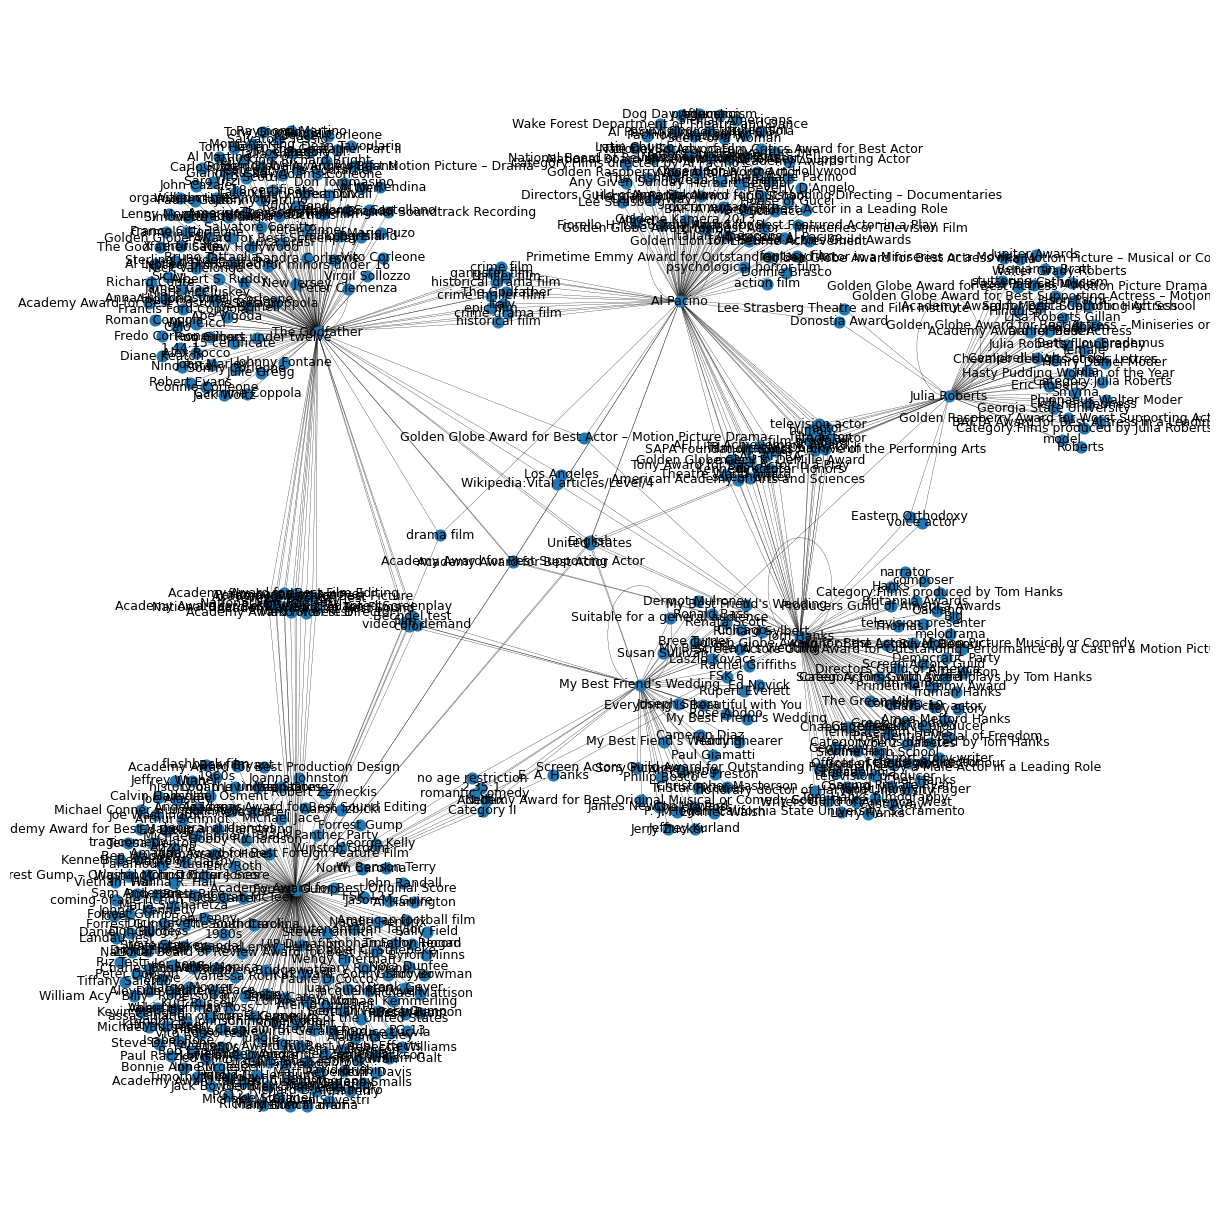

In [7]:
plt.figure(figsize=(12,12)) 
pos = nx.spring_layout(G)
nx.draw(G,pos, node_size=60,font_size=9, width = 0.2)
nx.draw_networkx_labels(G, pos, names, font_size=9)
plt.show()

## 2. Create a KG from the Movielens Dataset

In [8]:
# Obtain pairs of Movie Title - IDs from Movielens
df = movielens.load_pandas_df(
    MOVIELENS_DATA_SIZE,
    ("UserId", "ItemId", "Rating", "Timestamp"),
    title_col="Title",
    genres_col="Genres",
    year_col="Year",
)
movies = df[["Title", "ItemId"]].drop_duplicates().reset_index()

100%|██████████| 4.81k/4.81k [00:01<00:00, 4.25kKB/s]


In [9]:
movies["Title"][0:5]

0                  Kolya (1996)
1      L.A. Confidential (1997)
2           Heavyweights (1994)
3    Legends of the Fall (1994)
4           Jackie Brown (1997)
Name: Title, dtype: object

In [10]:
# For notebook testing
if MOVIELENS_SAMPLE:
    movies = movies.head(MOVIELENS_SAMPLE_SIZE)

In [11]:
movies.shape

(10, 3)

In [12]:
%%time
names = [t + " film" for t in movies["Title"]]
result = search_wikidata(names, extras=movies[["Title", "ItemId"]].to_dict())
result.head()

2025-05-02 11:48:45 WARNING  REQUEST FAILED or unexpected error querying links for Q267721: 429 Client Error: Too many requests. Please comply with the User-Agent policy to get a higher rate limit: https://meta.wikimedia.org/wiki/User-Agent_policy for url: https://query.wikidata.org/sparql?query=%0A++++PREFIX+entity%3A+%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0A++++%23partial+results%0A%0A++++SELECT+%3FpropUrl+%3FpropLabel+%3FvalUrl+%3FvalLabel%0A++++WHERE%0A++++%7B%0A++++++++hint%3AQuery+hint%3Aoptimizer+%27None%27+.%0A++++++++%7B%09BIND%28entity%3AQ267721+AS+%3FvalUrl%29+.%0A++++++++++++BIND%28%22N%2FA%22+AS+%3FpropUrl+%29+.%0A++++++++++++BIND%28%22identity%22%40en+AS+%3FpropLabel+%29+.%0A++++++++%7D%0A++++++++UNION%0A++++++++%7B%09entity%3AQ267721+%3FpropUrl+%3FvalUrl+.%0A++++++++++++%3Fproperty+%3Fref+%3FpropUrl+.%0A++++++++++++%3Fproperty+rdf%3Atype+wikibase%3AProperty+.%0A++++++++++++%3Fproperty+rdfs%3Alabel+%3FpropLabel%0A++++++++%7D%0A%0A++++++++%3FvalUrl+rdfs%3Alabel+%3

,name,original_entity,linked_entities,name_linked_entities,description,Title,ItemId
0,Kolya (1996) film,Q1141186,Q130232,drama film,1996 film by Jan Svěrák,Kolya (1996),242
1,Kolya (1996) film,Q1141186,Q157443,comedy film,1996 film by Jan Svěrák,Kolya (1996),242
2,Kolya (1996) film,Q1141186,Q100977416,Věra Uzelacová,1996 film by Jan Svěrák,Kolya (1996),242
3,Kolya (1996) film,Q1141186,Q104626218,Luboš Bíža,1996 film by Jan Svěrák,Kolya (1996),242
4,Kolya (1996) film,Q1141186,Q10819887,Andrei Chalimon,1996 film by Jan Svěrák,Kolya (1996),242


In [13]:
result["Title"].value_counts()

Title
Kolya (1996)                                                                   100
Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)     99
Hunt for Red October, The (1990)                                                98
L.A. Confidential (1997)                                                        79
Grease (1978)                                                                   73
Jackie Brown (1997)                                                             60
Remains of the Day, The (1993)                                                  60
Jungle Book, The (1994)                                                         54
Legends of the Fall (1994)                                                      53
Heavyweights (1994)                                                             48
Name: count, dtype: int64

In [14]:
# result.to_csv("movielens_" + MOVIELENS_DATA_SIZE + '_wikidata.csv', index = False)

In [15]:
number_movies = len(result["Title"].unique())
print(f"Number of movies: {number_movies}")

Number of movies: 10


In [16]:
# Record results for tests - ignore this cell
store_metadata("length_result", number_movies)